In [23]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2
from sklearn.metrics import log_loss

from utils import scoring_function

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (15, 8)
plt.rc('axes', axisbelow=True)

In [5]:
X_train = pd.read_feather('X_train_standard.f').set_index('sku')
X_val = pd.read_feather('X_val_standard.f').set_index('sku')
y_train = pd.read_feather('y_train.f').set_index('sku').iloc[:, 0]
y_val = pd.read_feather('y_val.f').set_index('sku').iloc[:, 0]
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(432587, 40) (144196, 40) (432587,) (144196,)


In [6]:
np.random.seed(10)
tf.random.set_seed(20)
random.seed(30)    

epochs = 300

# very simple NN
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(30, activation='softmax'))

adam = adam_v2.Adam(learning_rate=0.0005) # default: 0.001
model.compile(loss='categorical_crossentropy', optimizer=adam)

es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
h = model.fit(
    X_train,
    to_categorical(y_train, num_classes=30),
    validation_data=(X_val, to_categorical(y_val, num_classes=30)),
    epochs=epochs,
    batch_size=32,
    callbacks=[es]
)

2021-09-20 21:12:14.038684: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-20 21:12:14.420672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
13519/13519 [==============================] - 26s 987us/step - loss: 3.3472 - val_loss: 3.1767
Epoch 2/300
13519/13519 [==============================] - 14s 1ms/step - loss: 3.1658 - val_loss: 3.1472
Epoch 3/300
13519/13519 [==============================] - 17s 1ms/step - loss: 3.1431 - val_loss: 3.1360
Epoch 4/300
13519/13519 [==============================] - 13s 973us/step - loss: 3.1354 - val_loss: 3.1316
Epoch 5/300
13519/13519 [==============================] - 12s 879us/step - loss: 3.1288 - val_loss: 3.1281
Epoch 6/300
13519/13519 [==============================] - 12s 891us/step - loss: 3.1273 - val_loss: 3.1237
Epoch 7/300
13519/13519 [==============================] - 12s 881us/step - loss: 3.1265 - val_loss: 3.1250
Epoch 8/300
13519/13519 [==============================] - 15s 1ms/step - loss: 3.1269 - val_loss: 3.1256
Epoch 9/300
13519/13519 [==============================] - 16s 1ms/step - loss: 3.1224 - val_loss: 3.1218
Epoch 10/300
13519/13519 [==========

13519/13519 [==============================] - 11s 835us/step - loss: 3.1118 - val_loss: 3.1114
Epoch 77/300
13519/13519 [==============================] - 11s 826us/step - loss: 3.1108 - val_loss: 3.1124
Epoch 78/300
13519/13519 [==============================] - 11s 826us/step - loss: 3.1124 - val_loss: 3.1134
Epoch 79/300
13519/13519 [==============================] - 11s 834us/step - loss: 3.1116 - val_loss: 3.1125
Epoch 80/300
13519/13519 [==============================] - 11s 828us/step - loss: 3.1094 - val_loss: 3.1135
Epoch 81/300
13519/13519 [==============================] - 11s 826us/step - loss: 3.1110 - val_loss: 3.1112
Epoch 82/300
13519/13519 [==============================] - 11s 824us/step - loss: 3.1115 - val_loss: 3.1132
Epoch 83/300
13519/13519 [==============================] - 11s 825us/step - loss: 3.1107 - val_loss: 3.1112
Epoch 84/300
13519/13519 [==============================] - 11s 823us/step - loss: 3.1105 - val_loss: 3.1118
Epoch 85/300
13519/13519 [======

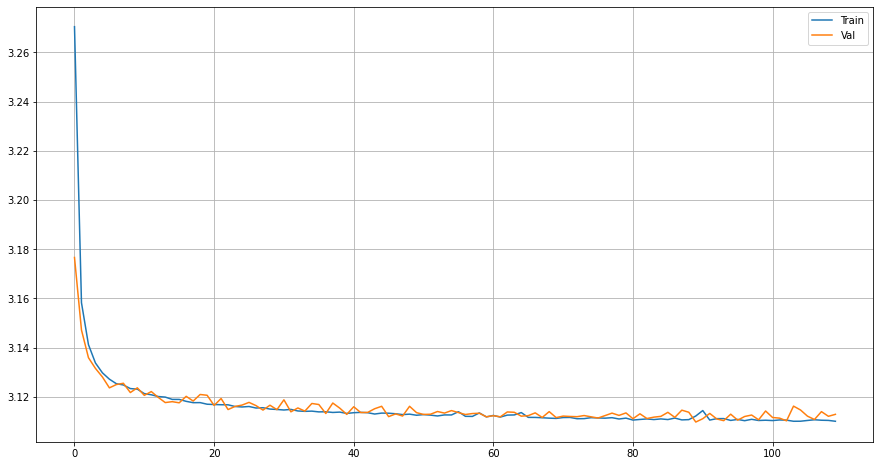

In [7]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['Train', 'Val'])
plt.grid();

In [24]:
print(np.argmin(h.history['val_loss']) + 1, min(h.history['val_loss']))

90 3.1098172664642334


In [25]:
%%time

# predictions
probs_train = model.predict(X_train)
probs_val = model.predict(X_val)

log_train = log_loss(y_train, probs_train)
log_val = log_loss(y_val, probs_val)
print('Log loss (train):', log_train)
print('Log loss (val):', log_val)

rps_train = scoring_function(y_train + 1, probs_train)
rps_val = scoring_function(y_val + 1, probs_val)
print('RPS (train):', rps_train)
print('RPS (val):', rps_val)

Log loss (train): 3.1101946759436045
Log loss (val): 3.1129438746426032
RPS (train): 3.6575219208069845
RPS (val): 3.671092105352449
CPU times: user 9.26 s, sys: 1.76 s, total: 11 s
Wall time: 8.23 s


### Save predictions

In [26]:
pd.DataFrame(probs_val).to_csv('3.2-probs-nn-two-layers-16-16.csv')

## Submission

In [27]:
X_test = pd.read_feather('X_test_standard.f').set_index('sku')
X_test

,sold_quantity_17,sold_quantity_18,sold_quantity_19,sold_quantity_20,sold_quantity_21,sold_quantity_25,sold_quantity_26,sold_quantity_27,sold_quantity_28,sold_quantity_29,sold_quantity_30,minutes_active_29,minutes_active_30,roll_mean_sold_30_11,roll_mean_sold_29_10,roll_mean_sold_28_9,roll_mean_sold_27_8,roll_mean_sold_26_7,roll_mean_sold_25_6,roll_mean_sold_24_5,roll_mean_minutes_30_11,roll_mean_minutes_29_10,roll_mean_minutes_26_7,roll_mean_minutes_25_6,roll_mean_minutes_24_5,roll_mean_price_30_11,roll_mean_price_29_10,roll_mean_price_27_8,roll_mean_price_25_6,roll_mean_price_24_5,roll_sum_zero_sold_30_11,roll_sum_zero_sold_24_5,roll_sum_shipping_logistic_type_fulfillment_30_11,roll_sum_shipping_logistic_type_cross_docking_30_11,roll_sum_shipping_logistic_type_fulfillment_28_9,roll_sum_shipping_logistic_type_fulfillment_26_7,roll_sum_shipping_logistic_type_fulfillment_25_6,roll_sum_shipping_logistic_type_fulfillment_24_5,roll_sum_shipping_payment_free_shipping_28_9,target_stock
sku,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
464801,-0.096217,-0.090172,-0.099056,-0.10158,0.097635,-0.084454,-0.079735,-0.102219,-0.094906,-0.118098,-0.115690,0.530162,0.533972,-0.095625,-0.094022,-0.087551,-0.087259,-0.087144,-0.087088,-0.086720,0.737185,0.744720,0.763959,0.769021,0.774894,0.000237,0.000191,-0.004176,-0.00350,-0.003556,0.527432,0.314442,0.479567,-0.297576,0.494024,0.50752,0.514066,0.520863,1.490386,-0.124437
645793,-0.000423,0.074500,-0.099056,-0.10158,0.018155,-0.084454,-0.079735,-0.102219,0.009552,-0.118098,-0.115690,0.530162,0.533972,-0.077280,-0.075858,-0.069648,-0.063206,-0.062798,-0.062530,-0.062069,0.737185,0.744720,0.763959,0.769021,0.774894,0.000237,0.000191,-0.004176,-0.00350,-0.003556,-0.073491,-0.266020,0.479567,-0.297576,0.494024,0.50752,0.514066,0.520863,1.490386,-0.116708
99516,-0.096217,-0.090172,-0.099056,-0.10158,-0.061326,0.064437,-0.079735,0.411154,0.427382,0.277992,0.364686,0.530162,0.533972,0.045019,0.027074,0.013903,0.002940,-0.008019,0.011142,0.005720,0.117517,0.128402,0.160092,0.169554,0.179085,-0.004385,-0.004378,-0.004405,-0.00362,-0.003677,-0.474106,-0.652995,-0.792469,-0.297576,-0.744423,-0.69828,-0.676118,-0.654889,-0.686343,-0.085792
538100,-0.000423,-0.090172,-0.099056,-0.10158,-0.061326,-0.010009,-0.079735,0.000456,0.114009,0.277992,0.268610,0.530162,0.533972,-0.016131,-0.021365,-0.039808,-0.045166,-0.050625,-0.044112,-0.049744,0.737185,0.744720,0.763959,0.769021,0.774894,-0.004385,-0.004378,-0.004405,-0.00362,-0.003677,-0.874720,-0.459507,0.479567,-0.297576,0.494024,0.50752,0.514066,0.520863,-0.686343,-0.085792
557191,-0.096217,-0.090172,-0.099056,-0.10158,-0.061326,-0.084454,-0.079735,-0.102219,-0.094906,-0.118098,0.076460,0.530162,0.533972,-0.107855,-0.118242,-0.117391,-0.117325,-0.105404,-0.105506,-0.105208,-1.222632,-1.352601,-1.631688,-1.609169,-1.588786,-0.004385,-0.004378,-0.004405,-0.00362,-0.003677,0.928047,0.894904,0.479567,-0.297576,0.494024,0.50752,0.514066,0.520863,-0.686343,-0.070334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129187,-0.096217,-0.090172,-0.099056,-0.10158,-0.061326,-0.084454,-0.079735,-0.102219,-0.094906,-0.118098,-0.115690,-1.943069,-1.502754,-0.120085,-0.118242,-0.117391,-0.117325,-0.117577,-0.117785,-0.117533,-2.213161,-2.217213,-2.138135,-2.111925,-2.088475,-0.004385,-0.004378,-0.004405,-0.00362,-0.003677,-2.677488,-2.781355,-2.700524,-0.297576,-2.602093,-2.50698,-2.461394,-2.418515,-0.686343,-0.085792
6707,-0.096217,-0.090172,-0.099056,-0.10158,-0.061326,-0.084454,-0.079735,-0.102219,-0.094906,-0.118098,-0.115690,-1.943069,-1.505581,-0.120085,-0.118242,-0.117391,-0.117325,-0.117577,-0.117785,-0.117533,-2.213329,-2.217213,-2.138135,-2.111925,-2.088475,-0.004385,-0.004378,-0.004405,-0.00362,-0.003677,-2.677488,-2.781355,-2.700524,-0.060230,-2.602093,-2.50698,-2.461394,-2.418515,-0.686343,0.084246
170355,-0.096217,-0.090172,-0.099056,-0.10158,-0.0613

In [28]:
# how many NAs 
X_test.isnull().sum()

sold_quantity_17                                       0
sold_quantity_18                                       0
sold_quantity_19                                       0
sold_quantity_20                                       0
sold_quantity_21                                       0
sold_quantity_25                                       0
sold_quantity_26                                       0
sold_quantity_27                                       0
sold_quantity_28                                       0
sold_quantity_29                                       0
sold_quantity_30                                       0
minutes_active_29                                      0
minutes_active_30                                      0
roll_mean_sold_30_11                                   0
roll_mean_sold_29_10                                   0
roll_mean_sold_28_9                                    0
roll_mean_sold_27_8                                    0
roll_mean_sold_26_7            

In [29]:
%%time

final_y_pred_nn = model.predict(X_test)

CPU times: user 8.49 s, sys: 1.39 s, total: 9.88 s
Wall time: 7.08 s


In [30]:
final_y_pred_nn

array([[9.14760213e-03, 1.71141755e-02, 2.43373681e-02, ...,
        1.58151016e-02, 1.16905477e-02, 7.09263142e-03],
       [3.47780553e-03, 1.08269900e-02, 2.05788705e-02, ...,
        1.38102239e-02, 9.98794567e-03, 5.23595279e-03],
       [1.00686535e-01, 2.05102652e-01, 1.51706174e-01, ...,
        3.69169097e-03, 2.84222886e-03, 1.74273481e-03],
       ...,
       [5.83326328e-04, 2.77547073e-03, 6.22398173e-03, ...,
        4.87173460e-02, 4.54919860e-02, 3.62462290e-02],
       [2.34685396e-03, 7.21130008e-03, 1.27811376e-02, ...,
        4.61968072e-02, 4.78049777e-02, 4.46558148e-02],
       [4.40580443e-05, 3.21988191e-04, 1.25636871e-03, ...,
        5.68320081e-02, 5.27581275e-02, 3.92932147e-02]], dtype=float32)

In [31]:
final_y_pred_nn.shape

(551472, 30)

## Creating DataFrame with predictions

In [32]:
%%time

X_test_sub = pd.DataFrame(final_y_pred_nn, columns=range(1, 31))
X_test_sub = X_test_sub.astype(float)
X_test_sub

CPU times: user 135 ms, sys: 35.9 ms, total: 171 ms
Wall time: 174 ms


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.009148,0.017114,0.024337,0.028336,0.033023,0.037369,0.046440,0.055468,0.058103,0.057534,0.047821,0.043026,0.041469,0.048662,0.054276,0.050846,0.045493,0.038657,0.032825,0.028910,0.032031,0.029343,0.028675,0.026190,0.021073,0.015412,0.013821,0.015815,0.011691,0.007093
1,0.003478,0.010827,0.020579,0.026291,0.033360,0.038820,0.049437,0.060064,0.063440,0.060843,0.051683,0.047398,0.042181,0.049839,0.054609,0.051280,0.047422,0.038141,0.031664,0.028114,0.031657,0.029375,0.028452,0.025030,0.019503,0.014565,0.012914,0.013810,0.009988,0.005236
2,0.100687,0.205103,0.151706,0.097559,0.074883,0.056147,0.047282,0.041032,0.035807,0.025101,0.019521,0.015853,0.011892,0.014474,0.013199,0.011450,0.012133,0.006985,0.006652,0.007026,0.007932,0.006140,0.006354,0.005508,0.004612,0.003258,0.003427,0.003692,0.002842,0.001743
3,0.011515,0.054058,0.086754,0.080007,0.084526,0.077281,0.074711,0.070278,0.068597,0.049815,0.040826,0.034830,0.026048,0.030785,0.029048,0.025298,0.024944,0.015598,0.014237,0.013747,0.015647,0.012402,0.012462,0.010593,0.008707,0.006453,0.006374,0.006521,0.004899,0.003037
4,0.003763,0.009313,0.016293,0.021080,0.026772,0.029407,0.040801,0.050222,0.056143,0.053658,0.046722,0.044139,0.041223,0.049088,0.054417,0.051266,0.052455,0.041802,0.036090,0.030300,0.036469,0.035820,0.033995,0.031453,0.025441,0.020342,0.019722,0.018639,0.014820,0.008345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551467,0.000035,0.000290,0.001076,0.002756,0.005182,0.006427,0.009292,0.012481,0.015886,0.021118,0.021988,0.022748,0.028799,0.031389,0.043328,0.038329,0.047303,0.053314,0.048187,0.042433,0.053818,0.059904,0.064704,0.058130,0.057809,0.054459,0.047478,0.058334,0.054957,0.038044
551468,0.000002,0.000020,0.000146,0.000556,0.001649,0.002447,0.004031,0.006910,0.008933,0.012754,0.015869,0.017846,0.022854,0.026106,0.041430,0.035355,0.046883,0.056903,0.048703,0.046660,0.053899,0.066559,0.064964,0.062761,0.058291,0.059401,0.056617,0.070027,0.063039,0.048387
551469,0.000583,0.002775,0.006224,0.011016,0.013416,0.013703,0.020440,0.022841,0.026475,0.031541,0.029045,0.029613,0.029426,0.038534,0.043577,0.041390,0.047545,0.047674,0.040056,0.036704,0.047091,0.049569,0.053500,0.051959,0.050742,0.042313,0.041791,0.048717,0.045492,0.036246
551470,0.002347,0.007211,0.012781,0.017974,0.019835,0.018744,0.025510,0.028011,0.032228,0.034587,0.031708,0.030690,0.028753,0.038525,0.042076,0.038329,0.043069,0.041720,0.036303,0.031686,0.040192,0.044192,0.046519,0.046593,0.045425,0.037534,0.038801,0.046197,0.047805,0.044656


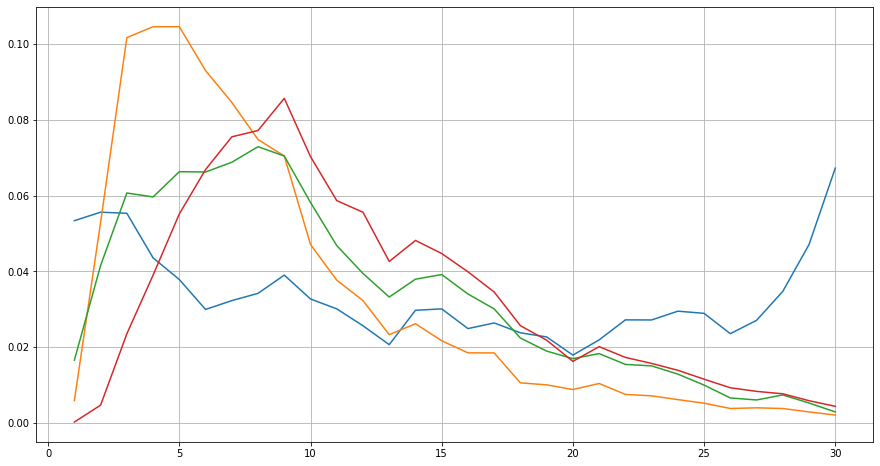

In [33]:
# check probabilites for random skus
for _ in range(1, 5):
    random_sku = X_test_sub.sample(1)
    plt.plot(range(1, 31), random_sku.values.squeeze())
plt.grid();

In [34]:
X_test_sub.sum(axis=1).value_counts().sort_index()

1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
      ..
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
Length: 42915, dtype: int64

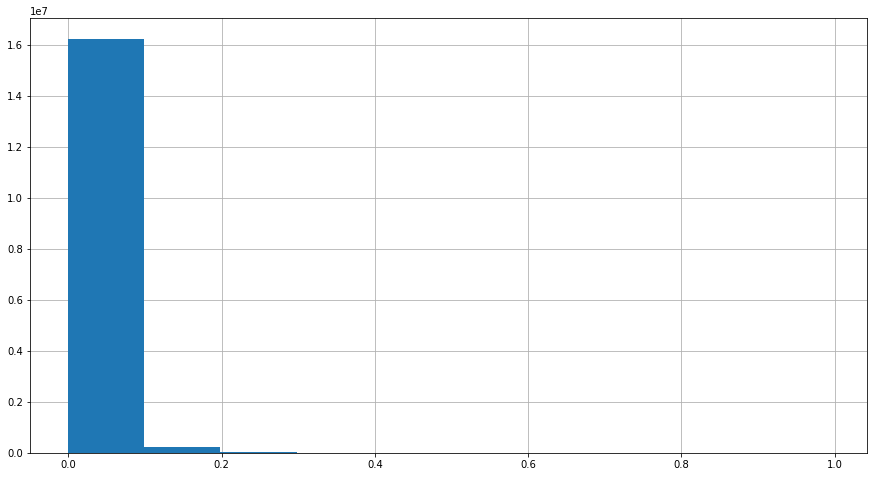

In [35]:
plt.hist(X_test_sub.values.reshape(-1))
plt.grid();

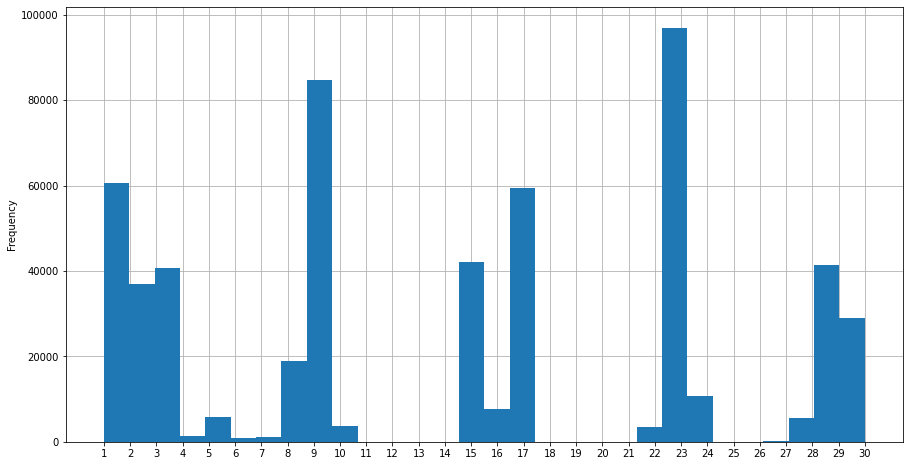

In [36]:
X_test_sub.idxmax(axis=1).plot.hist(bins=30)
plt.xticks(range(1, 31))
plt.grid();

Pretty different from LGBM predictions.   

In [37]:
X_test_sub.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
count,551472.000000,551472.000000,551472.000000,551472.000000,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05,5.514720e+05
mean,0.041519,0.042969,0.039269,0.033159,3.275507e-02,3.042589e-02,3.419103e-02,3.746800e-02,4.084180e-02,3.713907e-02,3.316577e-02,3.095540e-02,2.793179e-02,3.500702e-02,3.937471e-02,3.781813e-02,3.914118e-02,3.339893e-02,3.041476e-02,2.789151e-02,3.346232e-02,3.440946e-02,3.548341e-02,3.372752e-02,3.045006e-02,2.656431e-02,2.595150e-02,2.798318e-02,2.665676e-02,2.047522e-02
std,0.093415,0.067152,0.047043,0.032465,2.750811e-02,2.287149e-02,2.150388e-02,2.092256e-02,1.962511e-02,1.579530e-02,1.274424e-02,1.194399e-02,1.022831e-02,1.231907e-02,1.460633e-02,1.552498e-02,1.681575e-02,1.573777e-02,1.470007e-02,1.417069e-02,1.765077e-02,1.999741e-02,2.148920e-02,2.124724e-02,2.065727e-02,1.966340e-02,1.976030e-02,2.169539e-02,2.323736e-02,2.071977e-02
min,0.000000,0.000000,0.000000,0.000000,4.959386e-31,3.615619e-27,1.388425e-21,3.667198e-18,3.323436e-14,2.526447e-14,3.651418e-19,3.401964e-19,4.864451e-27,5.884443e-10,2.487311e-16,3.108792e-11,2.787327e-15,3.009565e-12,4.105628e-22,6.100181e-14,8.927707e-17,3.446428e-14,2.307557e-25,4.173526e-15,2.653174e-19,2.395721e-17,7.377509e-25,3.312603e-26,1.788172e-21,8.205613e-20
25%,0.000463,0.001701,0.003582,0.005870,8.779542e-03,1.054308e-02,1.561902e-02,1.961628e-02,2.491087e-02,2.526899e-02,2.437442e-02,2.315298e-02,2.191622e-02,2.842904e-02,3.172387e-02,2.859323e-02,2.748683e-02,2.017408e-02,1.756057e-02,1.525845e-02,1.734755e-02,1.491652e-02,1.465700e-02,1.290263e-02,1.028424e-02,7.523805e-03,7.130728e-03,7.703605e-03,5.922820e-03,3.899105e-03
50%,0.002388,0.007827,0.014755,0.019491,2.357495e-02,2.449209e-02,3.020070e-02,3.409456e-02,3.866166e-02,3.570614e-02,3.252674e-02,3.050002e-02,2.833743e-02,3.686162e-02,4.250943e-02,4.134883e-02,4.381262e-02,3.873951e-02,3.486476e-02,3.072040e-02,3.657893e-02,3.809961e-02,3.788114e-02,3.550550e-02,3.019520e-02,2.512150e-02,2.360611e-02,2.336671e-02,1.899517e-02,1.098274e-02
75%,0.024766,0.054387,0.069071,0.060370,5.672196e-02,4.934414e-02,5.250463e-02,5.563167e-02,5.741603e-02,5.067921e-02,4.341499e-02,3.994042e-02,3.595198e-02,4.419332e-02,5.034767e-02,4.936436e-02,5.111697e-02,4.586032e-02,4.248039e-02,4.010253e-02,4.897484e-02,5.234923e-02,5.487802e-02,5.241864e-02,4.814581e-02,4.219664e-02,4.147600e-02,4.624284e-02,4.530324e-02,3.510839e-02
max,0.992824,0.386677,0.246703,0.189021,1.478699e-01,1.354398e-01,1.118243e-01,1.055088e-01,1.431599e-01,7.084284e-01,7.825551e-02,7.649904e-02,5.823806e-02,6.414008e-02,7.816473e-02,7.541338e-02,7.472886e-02,2.570391e-01,7.141150e-02,6.748613e-02,6.733298e-02,1.548335e-01,8.636047e-02,1.852598e-01,8.461534e-02,1.052070e-01,2.551028e-01,1.159660e-01,4.647162e-01,1.963219e-01


In [38]:
%%time

X_test_sub.to_csv(
    '3.2-nn-two-layers-16-16.csv.gz',
    compression='gzip',
    index=False,
    header=False
)

CPU times: user 1min 44s, sys: 723 ms, total: 1min 45s
Wall time: 1min 47s
